# LLM Recall - Needle-in-a-haystack tests

- The Needle-in-a-Haystack test is designed to evaluate the performance of LLM RAG systems across different sizes of context windows. The testing process is straightforward: it asks an LLM to answer a specific question while the correct information ("the needle") is embedded within a large, unrelated context (the haystack).

- This test helps to better understand the retrieval abilities of models with very long context windows (some exceeding 200k tokens). Uniform retrieval performance is not guaranteed, as demonstrated in experiments showing that LLM in-context recall is prompt-dependent (see [LLM In-Context Recall is Prompt Dependent](https://arxiv.org/pdf/2404.08865v1))

- To our knowledge, this experiment has never been conducted on French statistical data.

We will also implement an improvement using multiple facts (needles) to better align with RAG expectations.

We will focus on opensource models (no API) and INSEE-related data. 

In [1]:
! mc cp -q s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/insee_documents_sample_ref_retrieval_evaluation.csv .

]11;?\mc: Configuration written to `/home/onyxia/.mc/config.json`. Please update your access credentials.
mc: Successfully created `/home/onyxia/.mc/share`.
mc: Initialized share uploads `/home/onyxia/.mc/share/uploads.json` file.
mc: Initialized share downloads `/home/onyxia/.mc/share/downloads.json` file.
`s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/insee_documents_sample_ref_retrieval_evaluation.csv` -> `insee_documents_sample_ref_retrieval_evaluation.csv`
Total: 4.69 MiB, Transferred: 4.69 MiB, Speed: 12.72 MiB/s


In [1]:
import pandas as pd 
data = pd.read_csv("./insee_documents_sample_ref_retrieval_evaluation.csv")

In [2]:
data.sample(1)

,content,source,title,insee_id,categories,date_diffusion,themes,collections,libelleAffichageGeo,intertitres,authors,subtitle
91,À l’issue de la conférence The European path t...,https://www.insee.fr/fr/information/6035940,Le SSPCloud: une fabrique créative pour accomp...,6035940,Courrier des statistiques,2022-01-20T10:00:00Z,NaN,NaN,NaN,Une refonte des appareils de production de la ...,"['Frédéric Comte', 'chef de projet', 'division...",NaN


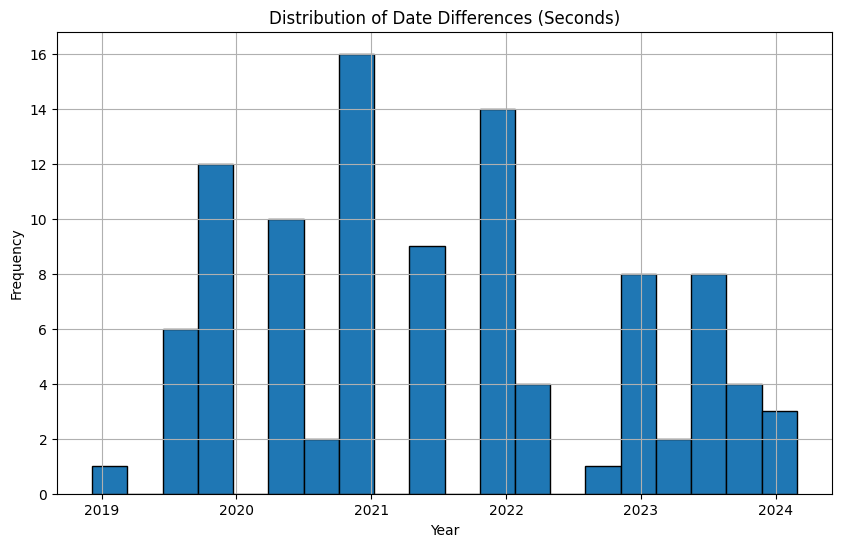

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

# Convert date strings to datetime objects
dates = [parser.isoparse(date_string) for date_string in data["date_diffusion"]]

# Sort the dates to ensure they are in chronological order
dates.sort()

# Plot the distribution of date differences
plt.figure(figsize=(10, 6))
plt.hist(dates, bins=20, edgecolor='black')
plt.title('Distribution of Date Differences (Seconds)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Needle in Haystack class

The task we can ask : 
- ask a figure : Quel est le taux de chômage de la population française au premier trimestre 2024 ? 
    Answer : 7.5
- Give a definition : Quel est la définition du coût salariale ? 
    Answer : Le coût salarial est constitué par l'ensemble des dépenses qui incombent à l'employeur pour l'emploi d'un salarié. Il se répartit en :
    un coût direct, composé principalement des salaires bruts et différents avantages salariaux ;
    un coût indirect formé essentiellement des cotisations patronales légales et conventionnelles et de diverses charges.
    Dans le coût direct, les avantages salariaux correspondent notamment aux avantages en nature, à l'intéressement et à la participation.
    Dans le coût indirect les charges autres que les cotisations patronales correspondent notamment à la formation professionnelle, aux frais de transport et aux œuvres sociales.
- ask to retrieve multiple figures ? 
    Donne moi le taux d'inflation, le taux de croissance et le taux de chômage au premier trimestre 2024.
    Answer : 
        - taux d'inflation : +2.2%
        - taux de croissance : 0.2%
        - taux de chômage : 7.5%

- A combien estime t on le nombre de logement supplémentaire par an entre 2024 et 2029 ? 
    Answer : 
    L’évaluation des besoins en logements dans la région des Pays de la Loire témoigne d’une dynamique soutenue, reflétant les enjeux démographiques et économiques de la région. Les besoins sont estimés à 23 700 logements par an entre 2024 et 2029.
- Qu'est ce que l'inflation ? 
    answer : L'inflation est la perte du pouvoir d'achat de la monnaie qui se traduit par une augmentation générale et durable des prix. 
- Comment est calculé l'inflation ? 
    answer : L’indice des prix à la consommation (IPC) est utilisé pour évaluer l’inflation.
- Comment s'appelle le jeu de données sur les échanges extérieurs de la France ? 
    Answer : DD_CNA_ECH_EXT


In [2]:
from typing import List, Optional, Dict, Tuple
import time
import re
import os
import json
import ast
import torch
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from transformers import (AutoConfig, AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig)
import logging 

logger = logging.getLogger(__name__)

class Evaluator:
    """
    Class to set up and run LLM-as-a-judge Needle-in-Haystack evaluation.
    """

    def __init__(self, tokenizer, model, question: str, gt_answer: str, prompt_eval: str, kwargs: Dict, verbose: bool = False):
        self.tokenizer = tokenizer
        self.model = model
        self.question_asked = question
        self.gt_answer = gt_answer
        self.pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer)
        self.prompt_template_eval = prompt_eval
        self.kwargs = kwargs
        self.verbose = verbose 

    def build_final_prompt(self, ground_truth_answer: str, generated_answer: str) -> str:
        """
        Build the evaluation prompt.
        """
        complete_prompt = self.prompt_template_eval.format(
            question=self.question_asked,
            ground_truth_answer=ground_truth_answer,
            generated_answer=generated_answer
        )
        instructions = [
            {"role": "assistant", "content": "You are a public statistics expert assistant."},
            {"role": "user", "content": complete_prompt}
        ]
        return self.tokenizer.apply_chat_template(instructions, tokenize=False, add_generation_prompt=True)

    def evaluation_parser(self, evaluation: str) -> Dict[str, Optional[str]]:
        """
        Parse the generated evaluation to extract the score and explanation.
        """
        pattern = r'\{.*?\}'
        matches = re.findall(pattern, evaluation)
        dictionaries = []

        for match in matches:
            try:
                dictionaries.append(ast.literal_eval(match))
            except (SyntaxError, ValueError):
                if self.verbose:
                    logger.error("Error parsing evaluation, returning default values.")
                    logger.info(f"Received evaluation: {evaluation}")
                return {"explanation": None, "score": None}

        if dictionaries:
            d = dictionaries[0]
            return {"explanation": d.get("explanation"), "score": int(d.get("score", 0))}
        return {"explanation": None, "score": None}

    def evaluate(self, generated_answers: List[str]) -> List[Dict[str, Optional[str]]]:
        """
        Run evaluations in batch.
        """
        final_prompts = [self.build_final_prompt(self.gt_answer, ans) for ans in generated_answers]
        evaluations = self.pipe(final_prompts, **self.kwargs)
        return [self.evaluation_parser(eval_[0]["generated_text"]) for eval_ in evaluations]


class LLMNeedleHaystackTester:
    """
    Class to set up Needle-in-Haystack test.
    """

    def __init__(
        self,
        needle: str,
        retrieval_question: str,
        llm_name: str,
        context_lengths_min: int = 50,
        context_lengths_max: int = 1000,
        context_lengths_num_intervals: int = 10,
        context_lengths: Optional[List[int]] = None,
        document_depth_percent_min: int = 0,
        document_depth_percent_max: int = 100,
        document_depth_percent_intervals: int = 35,
        document_depth_percents: Optional[List[int]] = None,
        results_version: int = 1,
        evaluation: bool = False,
        prompt_template: str = "",
        corpus_file: str = "./insee_documents_sample_ref_retrieval_evaluation.csv",
        save_results: bool = False,
        final_context_length_buffer: int = 200,
        kwargs: Dict = None,
        verbose: bool = False
    ):
        if not needle or not retrieval_question:
            raise ValueError("Needle and retrieval_question must be provided.")

        self.needle = needle
        self.retrieval_question = retrieval_question
        self.results_version = results_version
        self.save_results = save_results
        self.corpus_file = corpus_file
        self.verbose = verbose

        self.context_lengths = self._generate_intervals(context_lengths, context_lengths_min, context_lengths_max, context_lengths_num_intervals)
        self.document_depth_percents = self._generate_intervals(document_depth_percents, document_depth_percent_min, document_depth_percent_max, document_depth_percent_intervals)

        self.model, self.tokenizer = self._load_llm_model(llm_name)
        self.pipe = pipeline(task="text-generation", model=self.model, tokenizer=self.tokenizer)

        self.kwargs = kwargs if kwargs is not None else {"max_new_tokens": 200, "temperature": 0.2, "return_full_text": False, "do_sample": True, "batch_size": 1}
        self.prompt_template = prompt_template
        self.final_context_length_buffer = final_context_length_buffer or self._estimate_final_context_length_buffer()

        self.evaluator = None
        if evaluation:
            eval_model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
            eval_model, eval_tokenizer = self._load_llm_model(eval_model_name)
            self.evaluator = Evaluator(
                tokenizer=eval_tokenizer,
                model=eval_model,
                question=self.retrieval_question,
                gt_answer=self.needle,
                prompt_eval=INSTRUCTION_EVAL,
                verbose=True,
                kwargs={"max_new_tokens": 250,
                    "return_full_text": False,
                    "do_sample": False, 
                    "temperature": None,
                    "batch_size": 4,
                    "top_p" : None
                }
            )

    def _generate_intervals(self, values: Optional[List[int]], min_val: int, max_val: int, num_intervals: int) -> List[int]:
        if values is None:
            return list(np.round(np.linspace(min_val, max_val, num=num_intervals, endpoint=True)).astype(int))
        return [int(x) for x in values]

    def _load_llm_model(self, model_name: str) -> Tuple:
        """
        Load the tokenizer and model for the specified LLM.
        """
        tokenizer = AutoTokenizer.from_pretrained(
            model_name, use_fast=True, trust_remote_code=True, device_map="auto", padding_side='left'
        )
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=False
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_name, config=config, quantization_config=quantization_config,
            device_map="cuda" if torch.cuda.is_available() else "cpu", torch_dtype="auto", trust_remote_code=True
        )
        return model, tokenizer

    def _estimate_final_context_length_buffer(self) -> int:
        length_token_question = len(self._encode_text_to_tokens(self.retrieval_question))
        length_token_prompt = len(self._encode_text_to_tokens(self.prompt_template))
        length_token_generation = self.kwargs.get("max_new_tokens", 50)
        return length_token_question + length_token_prompt + length_token_generation + 10

    def _encode_text_to_tokens(self, text: str) -> List[int]:
        return self.tokenizer.encode(text)

    def _decode_tokens(self, tokens: List[int], context_length: Optional[int] = None) -> str:
        return self.tokenizer.decode(tokens[:context_length])

    def _encode_and_trim(self, context: str, context_length: int) -> str:
        tokens = self._encode_text_to_tokens(context)
        if len(tokens) > context_length:
            context = self._decode_tokens(tokens, context_length)
        return context

    def _insert_needle(self, needle: str, context: str, depth_percent: int, context_length: int) -> str:
        tokens_needle = self._encode_text_to_tokens(needle)
        tokens_context = self._encode_text_to_tokens(context)
        print("context size : ", len(tokens_context), " tokens")
        context_length -= self.final_context_length_buffer

        if len(tokens_context) + len(tokens_needle) > context_length:
            tokens_context = tokens_context[:context_length - len(tokens_needle)]
        
        tokens_new_context = [42]  # initialize

        if depth_percent == 100:
            tokens_new_context = tokens_context + tokens_needle
        else:
            insertion_point = int(len(tokens_context) * (depth_percent / 100))
            period_tokens = self._encode_text_to_tokens('.')
            # while the last token is not a '.' character (initializing with a non '.' encoded tokens)
            while tokens_new_context and (tokens_new_context[-1] not in period_tokens):
                insertion_point -= 1
                tokens_new_context = tokens_context[:insertion_point]

            tokens_new_context += tokens_needle + tokens_context[insertion_point:]

        new_context = self._decode_tokens(tokens_new_context)
        return new_context

    def _build_final_prompt(self, question: str, context: str) -> str:
        complete_prompt = self.prompt_template.format(context=context, question=question)
        instructions = [{"role": "user", "content": complete_prompt}]
        return self.tokenizer.apply_chat_template(instructions, tokenize=False, add_generation_prompt=True)

    def load_corpus(self, nb_sample=2) -> str:
        if os.path.exists(self.corpus_file):
            ext = self.corpus_file.split(".")[-1]
            if ext == "json":
                df = pd.read_json(self.corpus_file)
            elif ext == "csv":
                df = pd.read_csv(self.corpus_file)
            else:
                raise ValueError("File extension is not recognized")

            return ' '.join(df.sample(nb_sample, random_state=42)["content"].astype(str))
        else:
            raise FileNotFoundError("The provided file path does not exist")

    def result_exists(self, context_length: int, document_depth_percent: int) -> bool:
        """
        Check if a result already exists to avoid redundant processing.
        """
        if not os.path.exists("results/"):
            os.mkdir("results/")

        file_name = f"results/results_{self.results_version}.json"
        if not os.path.exists(file_name):
            return False

        with open(file_name, 'r') as file:
            data = json.load(file)

        result_key = f"{self.model.name_or_path}_{context_length}_{document_depth_percent}"
        return result_key in data.keys()

    def run(self, nb_sample: int = 2, generate_image: bool = False) -> Optional[List[str]]:
        """
        Run the Needle-in-Haystack test for each context length and document depth.
        """
        results = {}
        
        for context_length in self.context_lengths:
            for document_depth_percent in self.document_depth_percents:
                if self.result_exists(context_length, document_depth_percent):
                    logger.info(f"Result for context_length={context_length}, document_depth_percent={document_depth_percent} already exists.")
                else: 
                    # Load the corpus with a limit to avoid high memory usage
                    context = self.load_corpus(nb_sample)
                    new_context = self._insert_needle(self.needle, context, document_depth_percent, context_length)

                    prompt = self._build_final_prompt(self.retrieval_question, new_context)

                    # Generate answers
                    generated_answers = self.pipe(prompt, **self.kwargs)

                    # Store generated answer
                    result_key = f"{self.model.name_or_path}_{context_length}_{document_depth_percent}"
                    results[result_key] = generated_answers[0]['generated_text']

                    # Evaluate if evaluator exists
                    if self.evaluator:
                        evaluation_results = self.evaluator.evaluate([generated_answers[0]['generated_text']])
                        results[f"{self.model.name_or_path}_{context_length}_{document_depth_percent}_eval"] = evaluation_results

                    if self.save_results:
                        with open(f"results/results_{self.results_version}.json", 'w') as file:
                            json.dump(results, file, indent=4)

        if generate_image:
            self.generate_image()

        return results


    def generate_image(self) -> None:
        """
        Generate a heatmap image based on the evaluation results.
        """
        file_name = f"results/results_{self.results_version}.json"
        if not os.path.exists(file_name):
            logger.error(f"No results found to generate image.")
            return

        with open(file_name, 'r') as file:
            results = json.load(file)

        data = []
        for key, value in results.items():
            if "_eval" in key:
                model_name, context_length, document_depth_percent = key.split("_")[:3]
                eval_score = value[0]['score']
                data.append([int(context_length), int(document_depth_percent), eval_score])

        df = pd.DataFrame(data, columns=["Context Length", "Document Depth Percent", "Score"])
        df_pivot = df.pivot(columns="Context Length", index="Document Depth Percent", values="Score")
        
        cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
        sns.heatmap(df_pivot, cmap=cmap, annot=False, linewidths=0.5)
        plt.title("LLM Needle-in-Haystack Evaluation")
        plt.xlabel("Context Length (tokens)")
        plt.ylabel("Document Depth Percent (%)")
        # Rotate tick  labels on the x-axis
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.savefig(f"results/results_{self.results_version}.png")
        plt.show()



In [3]:
### Defining template 
INSTRUCTION_TEMPLATE  = """
Réponds à la question donnée en basant ta réponse uniquement sur les informations fournises en context. 

Context:
{context}

Question:
{question}

Réponse:
"""
INSTRUCTION_EVAL = """
Tu es un assistant IA spécialisé en Statistique Publique.
Veuillez agir en tant que juge impartial et évaluer la qualité de la réponse fournie par un assistant IA à la question de l'utilisateur affichée ci-dessous. 
Pour cette évaluation, vous devez principalement considérer le critère suivant :

Précision :
    Note 1 : La réponse n’a aucun rapport avec la référence.
    Note 2 : La réponse a une pertinence mineure mais ne correspond pas à la référence.
    Note 3 : La réponse est moyennement pertinente mais contient des inexactitudes.
    Note 4 : La réponse correspond à la référence mais comporte des omissions mineures.
    Note 5 : La réponse est tout à fait exacte et correspond parfaitement à la référence.

Commencez votre évaluation en fournissant une brève explication. Soyez le plus objectif possible. 
Après avoir fourni votre explication, vous devez évaluer la réponse sur une échelle de 1 à 5.
Vous répondrez en FRANÇAIS en respectant OBLIGATOIREMENT le format de réponse suivant : {{"explanation": "explication", "score": note}}

Par exemple, vous pourrez renvoyer :

Votre réponse : 
{{"explanation": "La réponse donnée ne correspond absolument pas à la réponse de référence.", "score": 1}}

---

Voici la réponse de référence : 
{ground_truth_answer}

Voici la question posée : 
{question}

Voici la réponse générée :
{generated_answer}

Votre réponse : 
"""


### Test 1

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


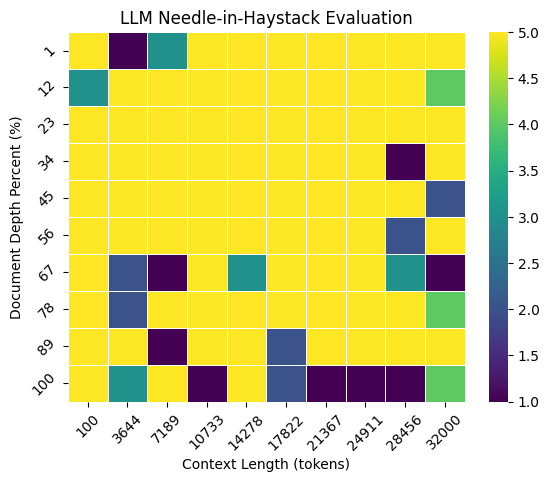

In [19]:
#llm_name = "mistralai/Mistral-7B-Instruct-v0.2" #context length : 32000
#llm_name = "meta-llama/Meta-Llama-3-8B-Instruct" # context length : 8000

# Set up logging
logging.basicConfig(level=logging.INFO)

# define necessary input
llm_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
question = "Qu'est ce que l'inflation ?"
needle =  "L'inflation est la perte du pouvoir d'achat de la monnaie qui se traduit par une augmentation générale et durable des prix."

# Instantiate a test with relevant parameters 
tester = LLMNeedleHaystackTester(
        needle=needle,
        retrieval_question=question,
        results_version=2,
        context_lengths_min=100,
        context_lengths_max=120000,
        context_lengths_num_intervals=10,
        document_depth_percent_min=1,
        document_depth_percent_max=100,
        document_depth_percent_intervals=10,
        llm_name=llm_name,
        evaluation=True,
        prompt_template=INSTRUCTION_TEMPLATE,
        save_results=True,
        verbose = True
    )

# Run the test
results = tester.run(nb_sample=10, generate_image=True)

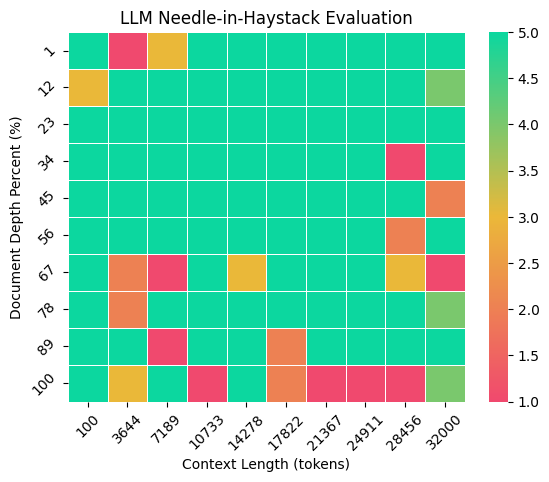

In [20]:
def generate_image(haystack : LLMNeedleHaystackTester) -> None:
    """
    Generate a heatmap image based on the evaluation results.
    """
    file_name = f"results/results_{haystack.results_version}.json"
    if not os.path.exists(file_name):
        logger.error(f"No results found to generate image.")
        return

    with open(file_name, 'r') as file:
        results = json.load(file)

    data = []
    for key, value in results.items():
        if "_eval" in key:
            model_name, context_length, document_depth_percent = key.split("_")[:3]
            eval_score = value[0]['score']
            data.append([int(context_length), int(document_depth_percent), eval_score])

    df = pd.DataFrame(data, columns=["Context Length", "Document Depth Percent", "Score"])
    df_pivot = df.pivot(columns="Context Length", index="Document Depth Percent", values="Score")
    
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
    sns.heatmap(df_pivot, cmap=cmap, annot=False, linewidths=0.5)
    plt.title("LLM Needle-in-Haystack Evaluation")
    plt.xlabel("Context Length (tokens)")
    plt.ylabel("Document Depth Percent (%)")
    # Rotate tick labels on the x-axis
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.savefig(f"results/results_{haystack.results_version}.png")
    plt.show()

generate_image(tester)